# CREATING SYNTHETIC DATA

Often, we want to study computational technique by studying existing models.
Frequently, we do not have true observational data, or we want to study the effectiveness
of algorithms with observational data that has different levels of noise.
In these situations, it is useful to create **synthetic observational data**.

We will illustrate the approach using the Wolf model.

The core idea is as follows.
We have an existing model that generates observations $y^{\star}(t)$,
a vector of floating species concentrations for each timepoint.
We add random noise, $n(t)$, to this vector (typically guassian).
The result, $y(t) = y^{\star} (t) + n(t)$, is our synthetic observational data.

# Preliminaries

In [1]:
!pip install -q tellurium

In [2]:
# Python packages used in this chapter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import urllib.request # use this library to download file from GitHub
import tellurium as te

# Wolf Model

In [3]:
WOLF_MODEL = """
// Created by libAntimony v2.12.0
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;

  // Species initializations:
  Glucose = 0;
  fructose_1_6_bisphosphate = 0;
  glyceraldehyde_3_phosphate = 0;
  glycerate_3_phosphate = 0;
  pyruvate = 0;
  Acetyladehyde = 0;
  External_acetaldehyde = 0;
  ATP = 3;
  ADP = 1;
  NAD = 0.5;
  NADH = 0.5;
  External_glucose = 0;
  ethanol = 0;
  Glycerol = 0;
  Sink = 0;
  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_inputFlux = 50;
  J1_k1 = 550;
  J1_Ki = 1;
  J1_n = 4;
  J2_k = 9.8;
  J3_k = 85.7;
  J4_kg = 323.8;
  J4_kp = 76411.1;
  J4_ka = 57823.1;
  J4_kk = 23.7;
  J5_k = 80;
  J6_k = 9.7;
  J7_k = 2000;
  J8_k1 = 375;
  J8_k2 = 375;
  J9_k = 28;
  J10_k = 80;

  // Other declarations:
  const compartment_, J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k, J3_k, J4_kg;
  const J4_kp, J4_ka, J4_kk, J5_k, J6_k, J7_k, J8_k1, J8_k2, J9_k, J10_k;
end
"""

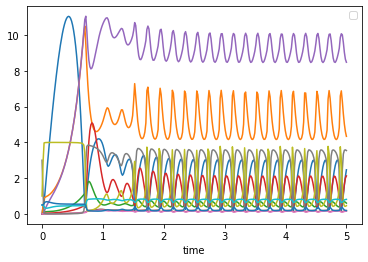

In [4]:
rr = te.loada(WOLF_MODEL)
data = rr.simulate(0, 5, 300)
WOLF_DF = pd.DataFrame(data, columns=data.colnames)
WOLF_DF = WOLF_DF.set_index("time")
_, ax = plt.subplots(1, figsize=(6, 4))
_ = WOLF_DF.plot(ax=ax)
plt.legend([])

# Helpers

In [19]:
def generateNoise(df, std, normalization_ser=None, is_plot=False):
    """
    Generates noise columns in a dataframe.
    
    Parameters
    ----------
    df: DataFrame
        columns: chemical species
        index: time
    std: float (standard deviation of generated noise)
    normalization_ser: Series (adjusts noise values)
    is_plot: bool (plot the noise)
    """
    if normalization_ser is None:
        dct = {n: 1 for n in df.columns}
        normalization_ser = pd.Series(dct)
    # Use the input DataFrame as a template
    noise_df = df.copy()
    # Create the noise data
    for column in noise_df.columns:
        noise_arr = np.random.normal(0, 0.2, len(noise_df))
        noise_df[column] = normalization_ser.loc[column]*noise_arr 
    if is_plot:
        noise_df.plot()
        plt.title("Generated Noise. Std=%2.2f" % std)
        _ = plt.legend([])
    return noise_df
                  
# Tests
df = generateNoise(WOLF_DF, 0.5, is_plot=False)
assert(isinstance(df, pd.DataFrame))
assert(len(WOLF_DF) == len(df))
print("OK!")

OK!


# Simple Noise

By simple noise, we mean that $n(t)$ is a matrix of identically distributed guassians.

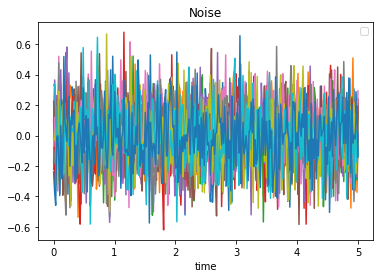

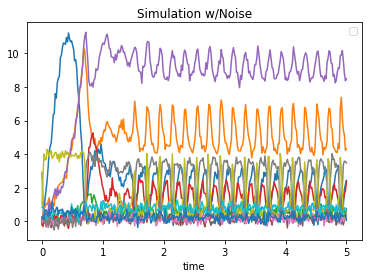

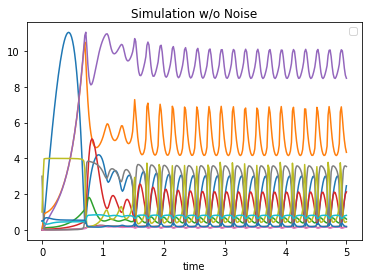

In [8]:
# Construct a mean weighted noise
noise_df = WOLF_DF.copy()  # Use WOLF_DF as a template
for column in noise_df.columns:
    noise_df[column] = np.random.normal(0, 0.2, len(WOLF_DF))
observed_df = WOLF_DF + noise_df
#


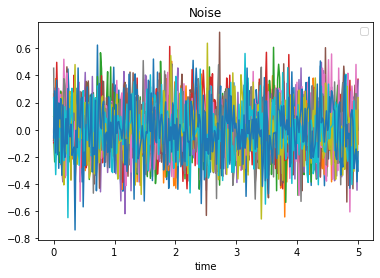

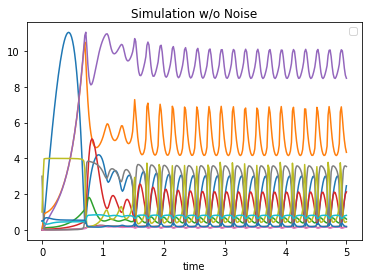

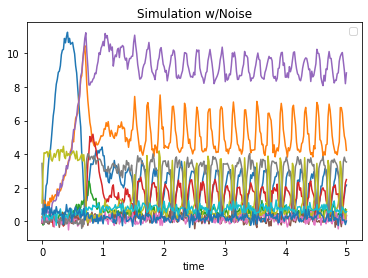

In [25]:
noise_df = generateNoise(WOLF_DF, 0.5)
simple_observed_df = WOLF_DF + noise_df
noise_df.plot(title="Noise")
plt.legend([])
WOLF_DF.plot(title="Simulation w/o Noise")
_ = plt.legend([])
simple_observed_df.plot(title="Simulation w/Noise")
_ = plt.legend([])

**Problem**: Little effect for large simulation outputs; big effect for small simulation outputs

# Noise Weighted by Mean

In [22]:
mean_ser = WOLF_DF.mean()
mean_ser

[Glucose]                       2.799252
[fructose_1_6_bisphosphate]     4.953619
[glyceraldehyde_3_phosphate]    0.562039
[glycerate_3_phosphate]         1.335435
[pyruvate]                      8.478951
[Acetyladehyde]                 0.157671
[External_acetaldehyde]         0.129876
[ATP]                           2.483823
[ADP]                           1.516177
[NAD]                           0.721953
[NADH]                          0.278047
dtype: float64

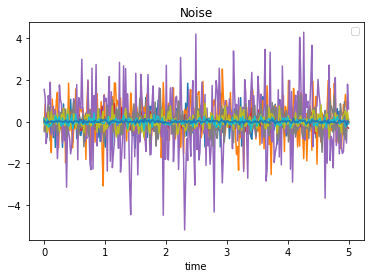

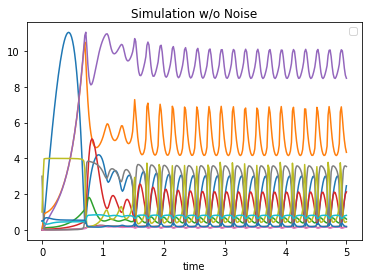

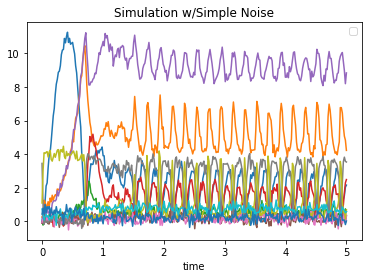

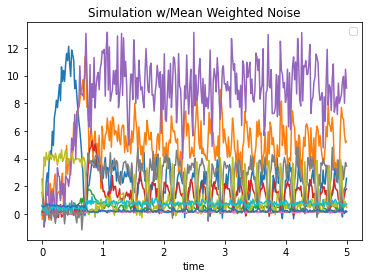

In [26]:
# Construct a mean weighted noise
noise_df = generateNoise(WOLF_DF, 0.5, normalization_ser=mean_ser)
mean_weighted_observed_df = WOLF_DF + noise_df
#
noise_df.plot(title="Noise")
plt.legend([])
WOLF_DF.plot(title="Simulation w/o Noise")
plt.legend([])
simple_observed_df.plot(title="Simulation w/Simple Noise")
_ = plt.legend([])
mean_weighted_observed_df.plot(title="Simulation w/Mean Weighted Noise")
_ = plt.legend([])